In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
import astropy.units as u
import glob
import os
import sys

sys.path.insert(0, '/home/aew492/lss-dipoles/code')
import tools
import generate_mocks as gm
from dipole import get_dipole, cmb_dipole

### load recovered dipole in data

### load recovered dipoles from mocks

In [3]:
# case dictionary
case_dicts_mock = gm.case_set(set_name='ideal_catwise')
# 'ideal_catwise' is just a single case
case_dict_mock = case_dicts_mock[0]

In [16]:
dir_results_mocks = '/scratch/aew492/lss-dipoles_results/results/results_mocks'

pattern = f"{dir_results_mocks}/dipole_comps_lambdas*{case_dict_mock['tag']}*.npy"
print(f"looking for {pattern}...")
fn_comps_mock = glob.glob(pattern)
n_trials = len(fn_comps_mock)
print(f"found {n_trials} files with this pattern")

looking for /scratch/aew492/lss-dipoles_results/results/results_mocks/dipole_comps_lambdas*_case-zeros-binary-0.0074-72.420*.npy...
found 1000 files with this pattern


In [17]:
# gather the recovered components
dipole_comps_mocks = []
Lambdas_mocks = []
# not necessary in order, careful!
for i in range(n_trials):
    result_dict = np.load(fn_comps_mock[i],  allow_pickle=True).item()
    dipole_comps_mock = result_dict['dipole_comps']
    dipole_comps_mocks.append(dipole_comps_mock)
    Lambdas_mocks.append(result_dict['Lambdas'])
dipole_comps_mocks = np.array(dipole_comps_mocks)
Lambdas_mocks = np.array(Lambdas_mocks)

In [18]:
# get the amplitudes and directions of the recovered dipole components
dipole_amps_mocks = []
dipole_dirs_mocks = []
for i in range(n_trials):
    dipole_amps_ = []
    dipole_dirs_ = []
    for j in range(len(Lambdas_mocks[0])):
        dipole_amp, dipole_dir = get_dipole(dipole_comps_mocks[i,j])
        dipole_amps_.append(dipole_amp)
        dipole_dirs_.append(dipole_dir)
    dipole_amps_mocks.append(dipole_amps_)
    dipole_dirs_mocks.append(dipole_dirs_)
dipole_amps_mocks = np.array(dipole_amps_mocks)

### plot recovered dipoles

#### amplitudes

In [27]:
# pick a few Lambdas
Lambdas = np.logspace(-3, -1, 5)
iLambdas = np.array([
    np.argmin(np.abs(Lambdas_mocks[0]-Lambda)) for Lambda in Lambdas
])
norm = mpl.colors.LogNorm(vmin=min(Lambdas), vmax=max(Lambdas))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool')

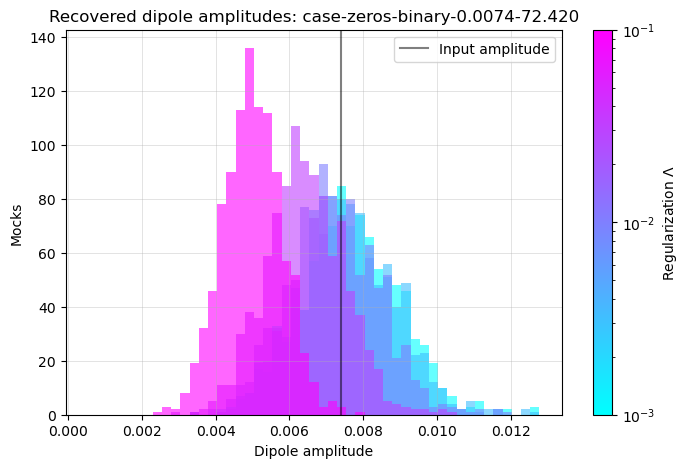

In [28]:
fig, ax = plt.subplots(figsize=(8,5))
bins = np.linspace(np.amin(dipole_amps_mocks), np.amax(dipole_amps_mocks), 50)
for i, iLambda in enumerate(iLambdas):
    _, _, _ = ax.hist(dipole_amps_mocks[:,iLambda], bins=bins, color=smap.to_rgba(Lambdas[i]), alpha=0.6, lw=1.5, histtype='stepfilled')
ax.grid(alpha=0.5, lw=0.5)
ax.axvline(case_dict_mock['dipole_amp'], c='k', alpha=0.5, label='Input amplitude')
ax.set_xlabel('Dipole amplitude')
ax.set_ylabel('Mocks')
ax.legend()
ax.set_title('Recovered dipole amplitudes: '+case_dict_mock['tag'][1:])
fig.colorbar(smap, ax=ax, label=r'Regularization $\Lambda$')

#### direction

In [29]:
# expected/input direction
input_dir = cmb_dipole()[1]

In [30]:
# pick a Lambda
Lambda = 1e-3
iLambda = np.argmin(np.abs(Lambdas_mocks[0]-Lambda))

Text(0.5, 0.98, 'Recovered dipole directions ($\\Lambda=$0.00100): case-zeros-binary-0.0074-72.420')

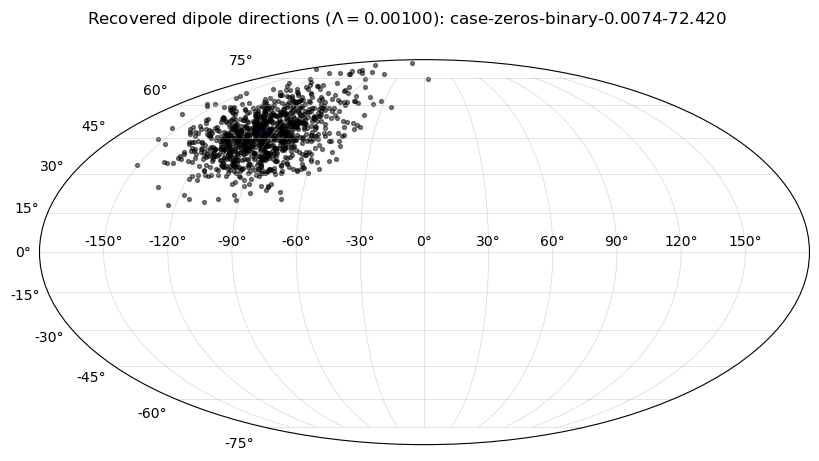

In [31]:
fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(111, projection='mollweide')
ax.grid(alpha=0.5, lw=0.5)

# recovered directions *galactic coords*
for dipdirs in dipole_dirs_mocks:
    dipdir = dipdirs[iLambda]
    theta, phi = tools.lonlat_to_thetaphi(dipdir.galactic.l, dipdir.galactic.b)
    ax.scatter(phi.wrap_at(np.pi * u.rad), np.pi/2 * u.rad - theta, alpha=0.4, c='k', s=6)

# input dipole
theta, phi = tools.lonlat_to_thetaphi(input_dir.galactic.l, input_dir.galactic.b)
ax.scatter(phi.wrap_at(np.pi * u.rad), np.pi/2 * u.rad - theta, alpha=0.7, c='b', marker='*', s=100)

# data dipole

fig.suptitle('Recovered dipole directions ('r'$\Lambda=$'f'{Lambdas_mocks[0][iLambda]:.5f}): '+case_dict_mock['tag'][1:])